In [1]:
import geopandas
import matplotlib.pyplot as plt
import numpy
import math
import pandas
import shapely
import datetime

In [2]:
# https://math.stackexchange.com/questions/2205764/how-to-define-the-boundary-of-a-set-of-points-clustered-on-a-unit-sphere/3497814#3497814
# https://stackoverflow.com/questions/9678624/convex-hull-of-longitude-latitude-points-on-the-surface-of-a-sphere/60958182#60958182
# https://www.springer.com/us/book/9781402002021

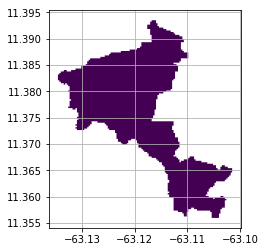

In [3]:
fig, ax = plt.subplots()
ax.grid(True)

carribean = geopandas.read_file('single.gpkg')
carribean['row'] = carribean.index
carribean = carribean[101:102]
carribean.plot(ax=ax, column='row')
lon, lat = carribean.iloc[0].geometry.exterior.xy

# We need to drop the last point because it is a repetition of the first point
lon = numpy.array(lon)[0:-1]
lat = numpy.array(lat)[0:-1]

x = numpy.cos(lon/360*math.pi*2) * numpy.cos(lat/360*math.pi*2)
y = numpy.sin(lon/360*math.pi*2) * numpy.cos(lat/360*math.pi*2)
z = numpy.sin(lat/360*math.pi*2)

In [4]:
start = datetime.datetime.now()

In [5]:
def make_great_circles(x, y, z):    
    great_circles = []
    i_s = []
    j_s = []
    for i in range(len(x)):
        for j in range(len(x)):
            node1 = [x[i], y[i], z[i]]
            node2 = [x[j], y[j], z[j]]
            great_circle = numpy.cross(node1, node2)
            great_circle = great_circle 
            i_s.append(i)
            j_s.append(j)
            great_circles.append(great_circle)
    great_circles = geopandas.GeoDataFrame({'gc': great_circles, 'i': i_s, 'j': j_s})
    return great_circles

great_circles_df = make_great_circles(x,y,z)

In [6]:
def select_edges(great_circles_df, x, y, z):
    edges = []
    for great_circle in great_circles_df.itertuples():
        disqualified = False
        for i in range(len(x)):
            direction = numpy.dot(great_circle.gc, [x[i], y[i], z[i]])
            if great_circle.j == i:
                continue
            if great_circle.i == i:
                continue
            if direction <= 0:
                disqualified = True
                break
        if not disqualified:
            edges.append(great_circle)
    return pandas.DataFrame(edges)

edges = select_edges(great_circles_df, x, y, z)

In [7]:
print(datetime.datetime.now() - start)

0:00:26.260742


In [8]:
def to_coords(x, y, z):
    lat = math.asin(z)*(180/math.pi)
    lon = math.atan(y/x)*(180/math.pi)
    return lon, lat

lines = []
points1 = []
points2 = []
for edge in edges.itertuples():
    shapely.geometry.LineString()
    x1 = x[edge.i]
    y1 = y[edge.i]
    z1 = z[edge.i]
    lon1, lat1 = to_coords(x1, y1, z1)
    x2 = x[edge.j]
    y2 = y[edge.j]
    z2 = z[edge.j]
    lon2, lat2 = to_coords(x2, y2, z2)
    lines.append(shapely.geometry.LineString([(lon1, lat1), (lon2, lat2)]))
    points1.append(shapely.geometry.Point(lon1, lat1))
    points2.append(shapely.geometry.Point(lon2, lat2))
    

edges['edges'] = lines
edges['points1'] = points1
edges['points2'] = points2
edges = geopandas.GeoDataFrame(edges).set_geometry('edges')

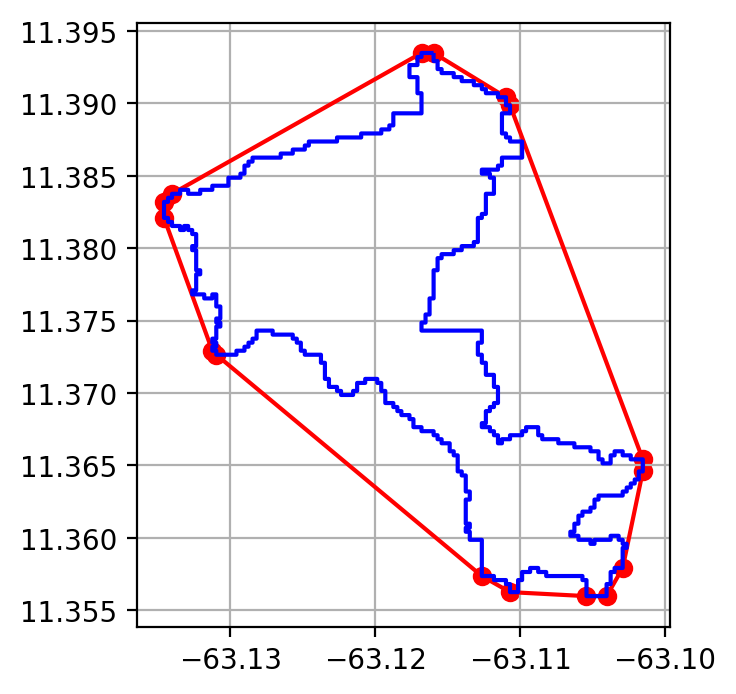

In [17]:
fig, ax = plt.subplots(dpi=200)
ax.grid(True)

edges.plot(ax=ax, color='r')
edges.set_geometry('points1').plot(ax=ax, color='r', marker='o')

carribean.geometry.exterior.plot(ax=ax, color='b')